In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astropy import units as u
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.table import Table
from bilby.core.result import read_in_result
from gwpopulation.utils import truncnorm, xp
from scipy.integrate import simpson

%matplotlib inline

### This notebook provides a quick highlight to test the distribution and the process, and to make sure it conforms to the GWTC-4 expectations.


##### Hyperparameters : Broken Power Law + 2 Peaks model

In [16]:
hyperparams_file = (
    "../data/"
    "baseline5_widesigmachi2_mass_NotchFilterBinnedPairingMassDistribution_"
    "redshift_powerlaw_mag_iid_spin_magnitude_gaussian_tilt_"
    "iid_spin_orientation_result.hdf5"
)

In [17]:
PARAMS_INFO = {
    "alpha_1": r"$\alpha_1$",
    "alpha_2": r"$\alpha_2$",
    "alpha_dip": r"$\alpha_d$",
    "NSmin": r"$M_\mathrm{min}$",
    "NSmax": r"$\gamma_\mathrm{low1}$",  # r"$M^\mathrm{gap}_\mathrm{low}$",
    "BHmin": r"$\gamma_\mathrm{high1}$",  # r"$M^\mathrm{gap}_\mathrm{high}$",
    "BHmax": r"$m_{\max}$",
    "A": r"$A$",
    "A2": r"$A2$",
    "UPPERmin": r"$\gamma_\mathrm{low2}$",
    "UPPERmax": r"$\gamma_\mathrm{high2}$",
    "mu1": r"$\mu_\mathrm{peak1}$",
    "sig1": r"$\sigma_\mathrm{peak1}$",
    "mix1": r"$c_1$",
    "mu2": r"$\mu_\mathrm{peak2}$",
    "sig2": r"$\sigma_\mathrm{peak2}$",
    "mix2": r"$c_2$",
    "n0": r"$\eta_0$",
    "n1": r"$\eta_1$",
    "n2": r"$\eta_2$",
    "n3": r"$\eta_3$",
    "n4": r"$\eta_4$",
    "n5": r"$\eta_5$",
    "absolute_mmax": r"$m_{\mathrm{abs},\max}$",
    "absolute_mmin": r"$m_{\mathrm{abs},\min}$",
}


def _get_map_sample(hyperparams) -> pd.Series:
    """
    Return MAP sample if prior is informative, else ML sample.
    """
    post = hyperparams.posterior.copy()
    if "log_prior" in post and post["log_prior"].nunique() > 1:
        score = post.log_likelihood + post.log_prior
        return post.iloc[np.argmax(score)]
    else:
        return post.iloc[np.argmax(post.log_likelihood)]


def GWTC4_broken_powerlaw_peaks(m, hyperparams):
    """
    GWTC-4 mass distribution.
    Broken power-law with two truncated Gaussian peaks and smooth filters.
    """
    # --- GWTC-4 model parameters ---
    alpha_1 = hyperparams["alpha_1"]
    alpha_2 = hyperparams["alpha_2"]
    alpha_dip = hyperparams["alpha_dip"]
    NSmin = hyperparams["NSmin"]
    NSmax = hyperparams["NSmax"]
    BHmin = hyperparams["BHmin"]
    BHmax = hyperparams["BHmax"]
    A = hyperparams["A"]
    A2 = hyperparams["A2"]
    UPPERmin = hyperparams["UPPERmin"]
    UPPERmax = hyperparams["UPPERmax"]
    mu1 = hyperparams["mu1"]
    sig1 = hyperparams["sig1"]
    mix1 = hyperparams["mix1"]
    mu2 = hyperparams["mu2"]
    sig2 = hyperparams["sig2"]
    mix2 = hyperparams["mix2"]
    n0 = hyperparams["n0"]
    n1 = hyperparams["n1"]
    n2 = hyperparams["n2"]
    n3 = hyperparams["n3"]
    n4 = hyperparams["n4"]
    n5 = hyperparams["n5"]
    absolute_mmin = 0.5
    absolute_mmax = 350.0

    # --- Truncated Gaussian peaks ---
    gaussian_peak1 = truncnorm(m, mu1, sig1, low=absolute_mmin, high=absolute_mmax)
    gaussian_peak2 = truncnorm(m, mu2, sig2, low=absolute_mmin, high=absolute_mmax)

    # --- Broken power-law with dip between NSmax and BHmin ---
    condlist = [m < NSmax, (m >= NSmax) & (m < BHmin), m >= BHmin]
    choicelist = [
        m**alpha_1,
        (m**alpha_dip) * (NSmax ** (alpha_1 - alpha_dip)),
        (m**alpha_2)
        * (NSmax ** (alpha_1 - alpha_dip))
        * (BHmin ** (alpha_dip - alpha_2)),
    ]
    plaw = xp.select(condlist, choicelist, default=0.0)

    # --- Smooth filters (notches + cutoffs) ---
    highpass_lower = 1.0 + (NSmin / m) ** n0
    notch_lower = 1.0 - A / ((1.0 + (NSmin / m) ** n1) * (1.0 + (m / BHmin) ** n2))
    notch_upper = 1.0 - A2 / (
        (1.0 + (UPPERmin / m) ** n3) * (1.0 + (m / UPPERmax) ** n4)
    )
    lowpass_upper = 1.0 + (m / BHmax) ** n5

    # --- Combine all components ---
    base = (
        (1.0 + mix1 * gaussian_peak1 + mix2 * gaussian_peak2)
        * plaw
        * notch_lower
        * notch_upper
        / highpass_lower
        / lowpass_upper
    )

    return base

In [18]:
data = read_in_result(hyperparams_file)
hyperparams = _get_map_sample(data)

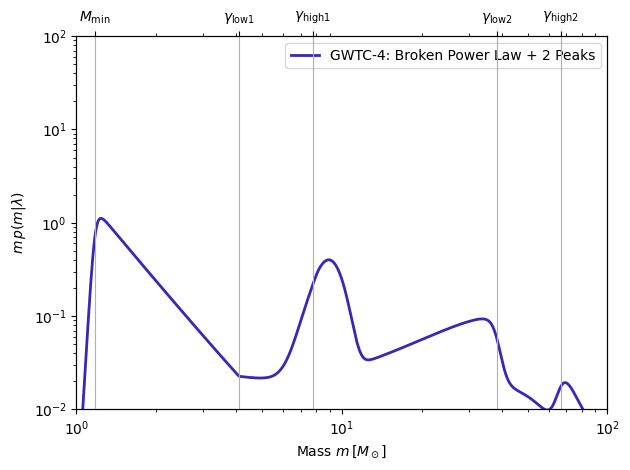

In [19]:
# mass grid
m = np.geomspace(1, 100, 1_000_000)
model = gwtc4 = GWTC4_broken_powerlaw_peaks(m, hyperparams)

# figure setup
fig, ax1 = plt.subplots()
ax1.set_xscale("log")
ax1.set_yscale("log")

# violet: '#9400D3', navy: '#001F75
ax1.plot(
    m,
    m * gwtc4,
    color="#2405ADE0",  # olor="#9400D3",
    linewidth=2,
    linestyle="-",
    label="GWTC-4: Broken Power Law + 2 Peaks",
)

# limits and labels
ax1.set_xlim(1, 100)
ax1.set_ylim(0.01, 100)
ax1.set_xlabel(r"Mass $m\,[M_\odot]$")
ax1.set_ylabel(r"$m\,p(m|\lambda)$")
ax1.legend()

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xscale(ax1.get_xscale())
ax2.set_xticks(
    [
        hyperparams["NSmin"],
        hyperparams["NSmax"],
        hyperparams["BHmin"],
        hyperparams["UPPERmin"],
        hyperparams["UPPERmax"],
    ]
)
ax2.set_xticklabels(
    [
        PARAMS_INFO["NSmin"],
        PARAMS_INFO["NSmax"],
        PARAMS_INFO["BHmin"],
        PARAMS_INFO["UPPERmin"],
        PARAMS_INFO["UPPERmax"],
    ]
)
ax2.grid(axis="x")
fig.tight_layout()

#### Plot simulated histograms (GWTC-4 distribustion) vs. theoretical PDF 

In [7]:
filename = "../data/pb2p_distribution_GWTC4.h5"
table = Table.read(filename)
table[:2]

mass_1,mass_ratio,a_1,a_2,cos_tilt_1,cos_tilt_2,redshift,mass_2
float64,float64,float64,float64,float64,float64,float64,float64
1.4003127807104705,0.934954537546301,0.25226035333012586,0.17081800015796333,-0.07445077428355917,0.9653381954834288,1.4144591708724004,1.3092287883093328
1.6007200708910987,0.9777425764328481,0.14350300511641967,0.05476595988100175,0.8604462381564546,0.7046866211743108,1.3044228619425053,1.5650921662608341


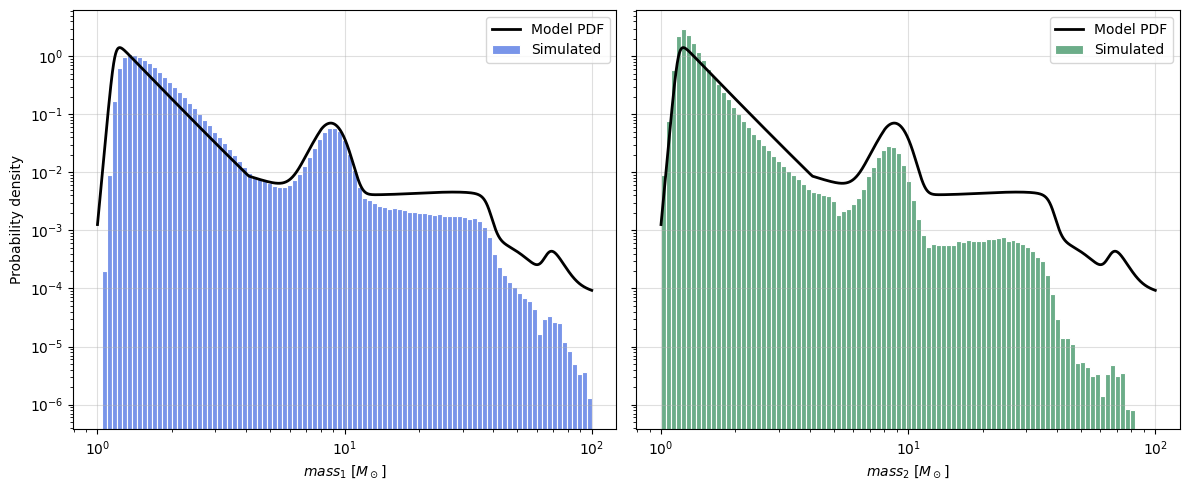

In [20]:
# --- Simulated distributions GWTC-4 ---
table = Table.read(filename)
m1 = table["mass_1"]
m2 = table["mass_2"]

# --- Theoretical GWTC-4 model (normalized PDF) ---
Z = simpson(model, m)
pdf_model = model / Z

# --- binning ---
lo = max(1.0, min(m1.min(), m2.min(), m.min()))
hi = min(100.0, max(m1.max(), m2.max(), m.max()))
bins = np.geomspace(lo, hi, 100)

# --- Plot simulated histograms vs. theoretical PDF ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, arr, label, color in [
    (axes[0], m1, r"$mass_1$", "royalblue"),
    (axes[1], m2, r"$mass_2$", "seagreen"),
]:
    # Normalized histogram of simulated data
    sns.histplot(
        arr,
        bins=bins,
        stat="density",
        color=color,
        alpha=0.7,
        edgecolor="white",
        linewidth=0.8,
        ax=ax,
        label="Simulated",
    )
    # Theoretical normalized PDF
    ax.plot(m, pdf_model, "k", lw=2, label="Model PDF")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(rf"{label} [$M_\odot$]")
    ax.grid(alpha=0.4)
    ax.legend()

axes[0].set_ylabel("Probability density")
plt.tight_layout()

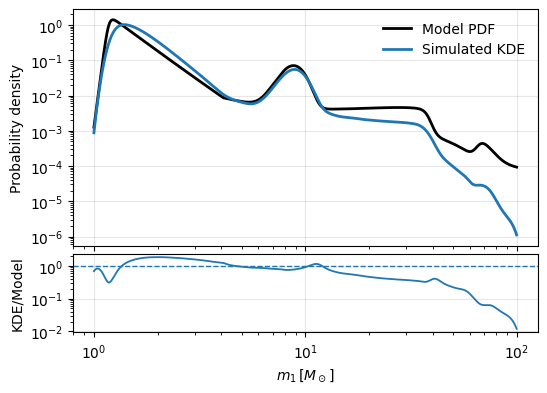

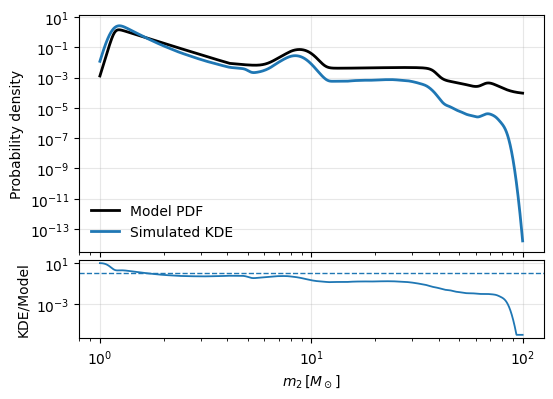

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson
from scipy.stats import gaussian_kde

pdf_model = pdf_model / simpson(pdf_model, m)


# -- KDE en log(m) avec Jacobien pour revenir en densité linéaire
def kde_on_logmass(samples, grid, bw=None):
    x = np.log(samples)
    gx = np.log(grid)
    kde = gaussian_kde(x) if bw is None else gaussian_kde(x, bw_method=bw)
    dens_log = kde(gx)
    dens_lin = dens_log / grid
    area = simpson(dens_lin, grid)
    return dens_lin / area if area > 0 else dens_lin


def plot_pdf_kde_with_ratio(grid, pdf_model, samples, xlabel):
    kde = kde_on_logmass(samples, grid)

    gs = dict(height_ratios=[3, 1], hspace=0.05)
    fig, (ax, rax) = plt.subplots(2, 1, figsize=(6, 4.2), sharex=True, gridspec_kw=gs)

    ax.plot(grid, pdf_model, lw=2, color="k", label="Model PDF")
    ax.plot(grid, kde, lw=2, label="Simulated KDE")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel("Probability density")
    ax.legend(frameon=False)
    ax.grid(alpha=0.3)

    ratio = np.clip(kde / np.maximum(pdf_model, 1e-300), 1e-6, 1e6)
    rax.plot(grid, ratio, lw=1.3)
    rax.axhline(1.0, ls="--", lw=1)
    rax.set_xscale("log")
    rax.set_yscale("log")
    rax.set_xlabel(xlabel)
    rax.set_ylabel("KDE/Model")
    rax.grid(alpha=0.3)
    return fig


grid = m[
    (m >= max(1.0, np.min([m1.min(), m2.min()])))
    & (m <= min(100.0, np.max([m1.max(), m2.max()])))
]

fig1 = plot_pdf_kde_with_ratio(
    grid, np.interp(grid, m, pdf_model), m1, r"$m_1\,[M_\odot]$"
)
fig2 = plot_pdf_kde_with_ratio(
    grid, np.interp(grid, m, pdf_model), m2, r"$m_2\,[M_\odot]$"
)
plt.show()

#### Plot of detections (GWTC-4 distribution) with observing scenarios vs. theoretical PDF.
The events shown passed the detection criteria based on the O4 HL configuration, with an SNR cutoff of 8.


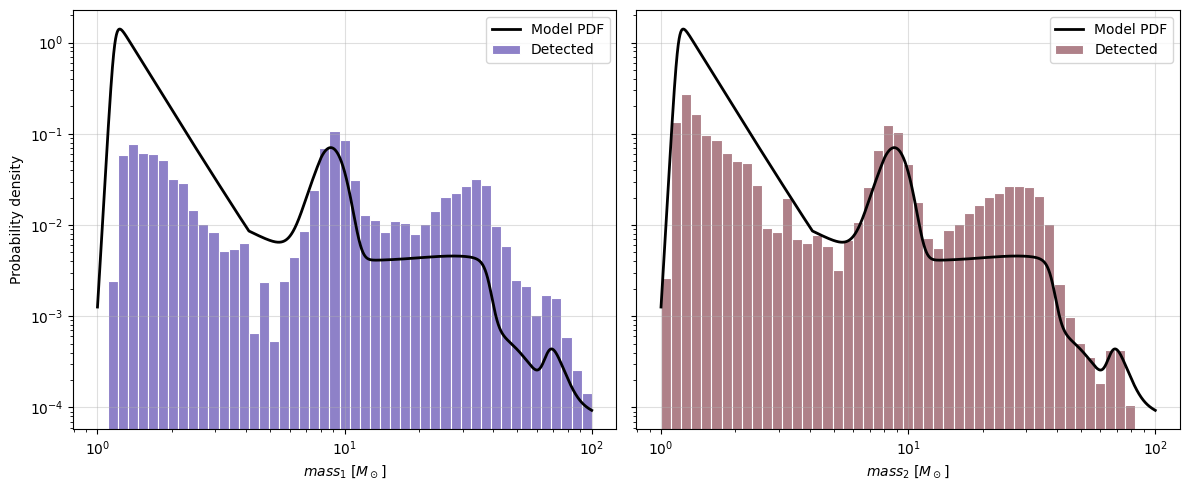

In [30]:
# --- Detection distributions GWTC-4 ---
detection = Table.read("../data/injections_04a_GWTC4.dat", format="ascii.fast_tab")


z = z_at_value(cosmo.luminosity_distance, detection["distance"] * u.Mpc).to_value()
zp1 = 1 + z

source_mass1 = detection["mass1"] / zp1
source_mass2 = detection["mass2"] / zp1


# --- Theoretical GWTC-4 model (normalized PDF) ---
Z = simpson(model, m)
pdf_model = model / Z

# --- binning ---
lo = max(1.0, min(source_mass1.min(), source_mass2.min(), m.min()))
hi = min(100.0, max(source_mass1.max(), source_mass2.max(), m.max()))
bins = np.geomspace(lo, hi, 50)

# --- Plot simulated histograms vs. theoretical PDF ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, arr, label, color in [
    (axes[0], source_mass1, r"$mass_1$", "#1E0492DF"),
    (axes[1], source_mass2, r"$mass_2$", "#600415DF"),
]:
    # Normalized histogram of simulated data
    sns.histplot(
        arr,
        bins=bins,
        stat="density",
        color=color,
        alpha=0.5,
        edgecolor="white",
        linewidth=0.8,
        ax=ax,
        label="Detected",
    )
    # Theoretical normalized PDF
    ax.plot(m, pdf_model, "k", lw=2, label="Model PDF")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(rf"{label} [$M_\odot$]")
    ax.grid(alpha=0.4)
    ax.legend()

axes[0].set_ylabel("Probability density")
plt.tight_layout()

np.float64(80.75878995505641)